<a href="https://colab.research.google.com/github/omaima-9/NLP/blob/main/CNN_With_Seg_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
# Load train
df = pd.read_csv('LabeledDataset.csv')

df=df[['commentText','Label']]
df


,commentText,Label
0,شمس مثقفة و جميلة وايد ... و احلام ههههععع ما ...,P
1,احلام اني حبيتها اكثر لان انظلمت كثير من النا...,N
2,كبرلفك والله دايضحكون عليج,N
3,والله كلامه صحيح عن شمس,N
4,ذكرى ما نسيناك وما حد بينسينا صوتك الجميل وطيب...,N
...,...,...
15045,مغروره تاليتج ياكلج الدود,P
15046,معقول رامز الكلب يعمل هالمقلب بسيرين هذا الاعد...,P
15047,NaN,P
15048,كنت بحبا بس المقطع رقم 2 خلاها قزرة,P


# 1. Preprocess

In [ ]:
!pip list
!git clone https://github.com/aub-mind/arabert


In [ ]:
from tensorflow.keras.layers import TextVectorization
import re
!pip install pyarabic
!pip install farasapy
from arabert.preprocess import ArabertPreprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor( model_name=model_name,
                                    remove_html_markup = False,
                                    replace_urls_emails_mentions = False,
                                    strip_tashkeel = True,
                                    strip_tatweel = True,
                                    insert_white_spaces = False,
                                    remove_non_digit_repetition = False,
                                    replace_slash_with_dash = None,
                                    map_hindi_numbers_to_arabic = True,
                                    apply_farasa_segmentation = None)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0010FFFF"  # wider range
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:842: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((


100%|██████████| 241M/241M [00:28<00:00, 8.44MiB/s]


[2022-12-04 16:11:37,386 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
def Pre_processing(comment):

  pat1 = '@[^ ]+' # Remove mentions
  pat2 = '#'      #
  pat3 = '[0-9]'  #remove Number
  pat4 = '[A-Za-z]' #remove english charctares
  combined_pat = '|'.join((pat1, pat2, pat3, pat4))
  comment = re.sub(combined_pat, '', comment)
  comment = re.sub('[ى]', 'ي', comment)
  comment = re.sub('[إأٱآا]', 'ا', comment)
  comment = re.sub('[ؤئ]', 'ء', comment)
  comment = re.sub('[ة]', 'ه', comment)
  comment = re.sub('[\n]', ' ', comment)
  comment = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), '', comment)  # remove punctuation
  comment=re.sub(r'(.)\1+', r'\1', comment) # remove repeated char like هههه  


  comment=remove_emoji(comment)

  comment=arabert_prep.preprocess(comment)

  return comment

In [ ]:
clean_df=df.copy()
for i in range(len(clean_df)):
  try:
    commentText=df['commentText'][i]
    commentText=Pre_processing(commentText)
    clean_df['commentText'][i]=commentText
  except:
    commentText

In [ ]:
clean_df

,commentText,Label
0,شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول,P
1,أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...,N
2,كبرلفك و+ اله دايضحكون عليج,N
3,و+ اله كلام +ه صحيح عن شمس,N
4,ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...,N
...,...,...
15045,مغرور +ه تاليتج ياكلج ال+ دود,P
15046,معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...,P
15047,NaN,P
15048,+كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره,P


In [ ]:

clean_df= clean_df.dropna()
clean_df=clean_df.drop_duplicates()
clean_df


,commentText,Label
0,شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول,P
1,أحلام +ان +ي حبي +ت +ها أكثر لان انظلم +ت كثير...,N
2,كبرلفك و+ اله دايضحكون عليج,N
3,و+ اله كلام +ه صحيح عن شمس,N
4,ذكرى ما نسي +نا +ك و+ ما حد ب+ ينسي +نا صوت +ك...,N
...,...,...
15044,ماذا نتظر من واحد +ه مسيحي +ه عاهر +ه ل+ +ك تف...,P
15045,مغرور +ه تاليتج ياكلج ال+ دود,P
15046,معقول رامز ال+ كلب يعمل هالمقلب ب+ سير +ين هذا...,P
15048,+كن +ت ب+ حبا بس ال+ مقطع رقم خلا +ها قزره,P


In [ ]:
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(clean_df['Label'])
clean_df['Label'] = encoder.transform(clean_df['Label'])
clean_df

In [ ]:
X = clean_df['commentText'].values
y = clean_df['Label'].values

In [ ]:
X[0]

'شمس مثقف +ه و جميل +ه وايد و أحلام هع ما أقول'

In [ ]:
len(X[0])


45

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel


In [ ]:
tokenizer = AutoTokenizer.from_pretrained( "aubmindlab/bert-base-arabertv2")

{'input_ids': [33, 91, 41, 3160, 4028, 25, 166, 2243, 25, 22111, 166, 4630, 165, 242, 331, 3871, 41, 41, 4630, 23, 5, 7579, 16, 10, 611, 2194, 312, 9002, 16, 730, 290, 20, 1255, 443, 3401, 195, 25, 1691, 25, 29, 594, 25, 289, 4170, 0, 29, 682, 25, 24433, 41, 41, 8249, 429, 217, 29, 13246, 5666, 7831, 313, 421, 194, 41, 48, 48, 48, 41, 6495, 15827, 20, 8654, 1912, 40208, 12749, 2, 1815, 28, 387, 20, 4521, 1890, 2, 584, 25, 41, 41, 15, 16, 2, 24918, 6202, 20, 7933, 1605, 16008, 10, 15228, 211, 223, 41, 41, 363, 6814, 25, 29, 363, 713, 25, 34009, 5, 25, 24110, 1243, 41, 93, 34], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
from tensorflow.python.ops import tensor_array_ops
# inputs is a dictionary containing inputs_ids, attention_masks and token_type_ids as pytorch tensors
# clean_df['toke']
# for sentence in clean_df.commentText:
#   inputs= tokenizer.encode_plus(str(sentence), return_tensors='pt')
#   clean_df['toke'][sentence]=inputs['input_ids'][0]
toke=[]
for sentence in X:
  m=np.zeros(800)
  inputs= np.array(tokenizer(str(sentence), padding=True,
                    return_tensors='pt',truncation=False, max_length=800)['input_ids'][0] )
  m[:inputs.shape[0]-2]=inputs[1:-1]
  toke.append(m.astype(int))
# tokenized=(tokenizer.encode_plus(str(sentence), return_tensors='pt')['input_ids'][0] for sentence in clean_df.commentText)


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2354: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [ ]:
print(toke[0])

[ 3160  4028    25   166  2243    25 22111   166  4630   165   242   331
  3871     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
tokenized_text = tf.convert_to_tensor(toke)

In [ ]:
len(tokenized_text)

10862

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
type(X)

numpy.ndarray

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((tokenized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
dataset.snapshot

<bound method DatasetV2.snapshot of <PrefetchDataset element_spec=(TensorSpec(shape=(None, 800), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>>

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 800), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# 2. Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Conv1D

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 200))

# Bidirectional LSTM Layer
model.add(Conv1D(128,5,activation='relu'))
model.add(Bidirectional(LSTM(32, activation='tanh')))
# model.add(GlobalMaxPooling1D())

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 200)         40000200  
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         128128    
                                                                 
 bidirectional_18 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                     

In [ ]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
475/475 [==============================] - 604s 1s/step - loss: 0.5241 - accuracy: 0.7371 - val_loss: 0.3195 - val_accuracy: 0.8810
Epoch 2/5
475/475 [==============================] - 597s 1s/step - loss: 0.3067 - accuracy: 0.8747 - val_loss: 0.2200 - val_accuracy: 0.9148
Epoch 3/5
475/475 [==============================] - 602s 1s/step - loss: 0.2042 - accuracy: 0.9255 - val_loss: 0.1073 - val_accuracy: 0.9639
Epoch 4/5
475/475 [==============================] - 597s 1s/step - loss: 0.1293 - accuracy: 0.9533 - val_loss: 0.0806 - val_accuracy: 0.9801
Epoch 5/5
475/475 [==============================] - 602s 1s/step - loss: 0.0859 - accuracy: 0.9718 - val_loss: 0.0427 - val_accuracy: 0.9861


In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

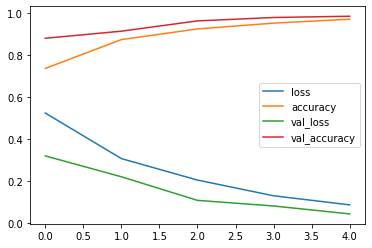

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = vectorizer('شكلها زي الحيوان')
# input_text

In [ ]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 906ms/step


In [ ]:
(np.rint(res)).astype(int)

array([[0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
len(batch_X)

16

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res

array([[0.2216914]], dtype=float32)

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
from sklearn.metrics import f1_score
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [ ]:
t=[]
p=[]
for batch in test.as_numpy_iterator(): 

    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat =(np.rint(model.predict(X_true))).astype(int)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    t=np.concatenate((t,y_true), axis=None)
    p=np.concatenate((p,yhat), axis=None)
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    f1_score(y_true,yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()},F1_score:{f1_score(t,p)}')

Precision: 0.9580574035644531, Recall:0.9886105060577393, Accuracy:0.9552238583564758,F1_score:0.9730941704035874


# 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('انت حيوان')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 135ms/step


In [ ]:
res

array([[0.11611608]], dtype=float32)

In [ ]:
clean_df.columns[1:]

Index(['Label'], dtype='object')

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    text = '{}: {}'.format("Label",(np.rint(results)).astype(int))
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://83d3fba6555a1ccd.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
